In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
# If using Google Colab
print("Mounting Google Drive...")
drive.mount('/content/drive/')
project_path = '/content/drive/MyDrive/DS_project/'

Mounting Google Drive...
Mounted at /content/drive/


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
df = pd.read_csv(project_path+'ISMN_data_clean.csv')

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

feature_cols = ['precipitation', 'temperature']
target_col = 'soil_moisture'

print(f"\nFeature columns: {feature_cols}")
print(f"Target column: {target_col}")

columns_to_keep = ['date'] + feature_cols + [target_col]
df_clean = df[columns_to_keep].dropna()

print(f"\nOriginal rows: {len(df)}")
print(f"Rows after removing NaN: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} rows with missing values")

print(f"\nData Summary:")
print(df_clean[feature_cols + [target_col]].describe())


Date range: 2018-01-01 00:00:00 to 2025-11-03 00:00:00

Feature columns: ['precipitation', 'temperature']
Target column: soil_moisture

Original rows: 873096
Rows after removing NaN: 840893
Removed 32203 rows with missing values

Data Summary:
       precipitation    temperature  soil_moisture
count  840893.000000  840893.000000  840893.000000
mean        0.095987      10.902150       0.279765
std         0.803711       6.413584       0.146696
min         0.000000     -23.289400       0.000000
25%         0.000000       6.203800       0.165800
50%         0.000000      10.526000       0.264900
75%         0.042500      15.322600       0.385500
max        87.980000      34.714600       0.884700


In [ ]:

df_daily = pd.read_csv(project_path+'ISMN_data_clean.csv')
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily = df_daily.set_index('date')

df_daily['precip_7d_sum'] = df_daily['precipitation'].rolling(window=7).sum()
df_daily['precip_30d_sum'] = df_daily['precipitation'].rolling(window=30).sum()
df_daily['temp_7d_avg'] = df_daily['temperature'].rolling(window=7).mean()
df_daily = df_daily.dropna()

print(f"Päevapõhiseid ridu kokku: {len(df_daily)}")
print(df_daily.head())

# data: 80% train, 20% test
train_size = int(len(df_daily) * 0.8)
train_data = df_daily.iloc[:train_size]
test_data = df_daily.iloc[train_size:]

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

feature_cols = ['precipitation', 'temperature', 'precip_7d_sum', 'precip_30d_sum', 'temp_7d_avg']
target_col = 'soil_moisture'

X_train_scaled = scaler_X.fit_transform(train_data[feature_cols])
y_train_scaled = scaler_y.fit_transform(train_data[[target_col]])

X_test_scaled = scaler_X.transform(test_data[feature_cols])
y_test_scaled = scaler_y.transform(test_data[[target_col]])

print("\n--- Random Forest Training ---")
rf_model = RandomForestRegressor(n_estimators=150, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train_scaled.ravel())

# Predicting
rf_pred_scaled = rf_model.predict(X_test_scaled)
rf_pred = scaler_y.inverse_transform(rf_pred_scaled.reshape(-1, 1))

y_test_actual = test_data[target_col].values

# Metrikad
rf_rmse = np.sqrt(mean_squared_error(y_test_actual, rf_pred))
rf_mae = mean_absolute_error(y_test_actual, rf_pred)
rf_r2 = r2_score(y_test_actual, rf_pred)

print(f"\n--- Results ---")
print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"Random Forest MAE:  {rf_mae:.4f}")
print(f"Random Forest R²:   {rf_r2:.4f}")



Päevapõhiseid ridu kokku: 835310
            soil_moisture sm_source     station  sm_depth_from  sm_depth_to  \
date                                                                          
2018-01-30         0.4785  fallback  CocklePark            0.0          0.3   
2018-01-31         0.4778  fallback  CocklePark            0.0          0.3   
2018-02-01         0.4773  fallback  CocklePark            0.0          0.3   
2018-02-02         0.4765  fallback  CocklePark            0.0          0.3   
2018-02-03         0.4805  fallback  CocklePark            0.0          0.3   

                      sensor  temperature ta_source  ta_depth_from  \
date                                                                 
2018-01-30  Cosmic-ray-Probe       4.5920      good           -2.0   
2018-01-31  Cosmic-ray-Probe       3.3417      good           -2.0   
2018-02-01  Cosmic-ray-Probe       3.7010      good           -2.0   
2018-02-02  Cosmic-ray-Probe       4.0235      good           -

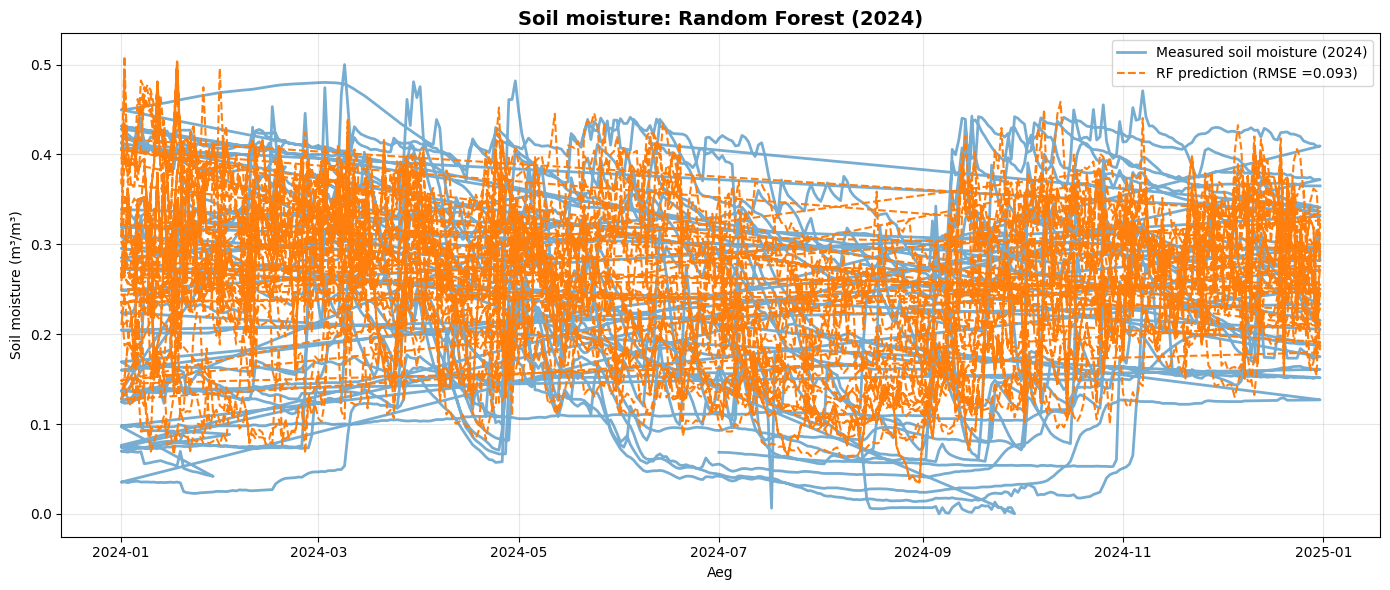

In [ ]:
# 2024 data plotting


test_data_2024 = test_data[test_data.index.year == 2024]

mask_2024 = (test_data.index.year == 2024)

rf_pred_2024 = rf_pred[mask_2024]
y_test_2024 = test_data_2024[target_col].values

plt.figure(figsize=(14, 6))
plt.plot(test_data_2024.index, y_test_2024,
         label='Measured soil moisture (2024)', alpha=0.6, linewidth=2)

plt.plot(test_data_2024.index, rf_pred_2024,
         label=f'RF prediction (RMSE ={rf_rmse:.3f})',
         linestyle='--', linewidth=1.5)

plt.title('Soil moisture: Random Forest (2024)', fontsize=14, fontweight='bold')
plt.xlabel('Aeg')
plt.ylabel('Soil moisture (m³/m³)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Graafik Kert

test_data["date"] = pd.to_datetime(test_data["date"])

# Add actual + predicted into same DataFrame
df_plot = test_data.copy()
df_plot["actual"] = y_test_actual
df_plot["pred"] = rf_pred.flatten()

# Filter only 2024
df_2024 = df_plot[df_plot["date"].dt.year == 2024]

# Compute daily averages across all stations
daily_mean = df_2024.groupby(df_2024["date"].dt.date)[["actual", "pred"]].mean()

# Plot
plt.figure(figsize=(16,6))

plt.plot(daily_mean.index, daily_mean["actual"],
         label="Measured soil moisture average (all stations)",
         color="black", linewidth=2)

plt.plot(daily_mean.index, daily_mean["pred"],
         label="RF prediction",
         color="green", linestyle="--", linewidth=2)

plt.title("Measured daily soil moisture average vs RF prediction (2024)",
          fontsize=15, fontweight="bold")

plt.xlabel("Date")
plt.ylabel("Soil moisture (m³/m³)")

plt.legend(
    loc="lower left",
    fontsize=14,
    frameon=True,
    borderpad=1.2,
    handlelength=3,
    handletextpad=1.2,
    markerscale=1.5
)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
estonian_stations = [
    'Haapsalu_clean.csv',
    'Jogeva_clean.csv',
    'Johvi_clean.csv',
    'Kuusiku_clean.csv',
    'Laane-Nigula_clean.csv',
    'Pakri_clean.csv',
    'Tallinn-Harku_clean.csv',
    'Tartu-Toravere_clean.csv',
    'Tiirikoja_clean.csv',
    'Turi_clean.csv',
    'Vaike-Maarja_clean.csv',
    'Valga_clean.csv',
    'Viljandi_clean.csv',
    'Voru_clean.csv',
    'Kihnu_clean.csv',
    'Kunda_clean.csv',
    'Narva_clean.csv',
    'Parnu_clean.csv',
    'Ruhnu_clean.csv',
    'Sorve_clean.csv',
    'Virtsu_clean.csv',
    'Heltermaa_clean.csv',
    'Roomassaare_clean.csv',
    'Ristna_clean.csv'
]

predictions_dict = {}

est_data_path = project_path + 'Est data/'

for station_file in estonian_stations:
    station_name = station_file.replace('_clean.csv', '')
    print(f"\n--- {station_name} ---")

    # Load station
    file_path = est_data_path + station_file
    df_est = pd.read_csv(file_path)

    # Translate
    df_est.columns = ['date', 'precipitation', 'temperature']
    df_est['date'] = pd.to_datetime(df_est['date'])
    df_est = df_est.set_index('date')

    print(f"Ridu enne töötlust: {len(df_est)}")

    # Add addons to the data
    df_est['precip_7d_sum'] = df_est['precipitation'].rolling(window=7).sum()
    df_est['precip_30d_sum'] = df_est['precipitation'].rolling(window=30).sum()
    df_est['temp_7d_avg'] = df_est['temperature'].rolling(window=7).mean()
    df_est = df_est.dropna()

    print(f"Ridu pärast ettevalmistust: {len(df_est)}")

    X_est = df_est[feature_cols]
    X_est_scaled = scaler_X.transform(X_est)

    y_pred_scaled = rf_model.predict(X_est_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

    df_est['predicted_soil_moisture'] = y_pred
    predictions_dict[station_name] = df_est

    #
    print(f"Ennustatud mullaniiskuse vahemik: {y_pred.min():.4f} - {y_pred.max():.4f}")
    print(f"Keskmine: {y_pred.mean():.4f}")

print(f"\n Kokku töödeldud jaamasid: {len(predictions_dict)}")


--- Haapsalu ---
Ridu enne töötlust: 2906
Ridu pärast ettevalmistust: 2877
Ennustatud mullaniiskuse vahemik: 0.1207 - 0.6643
Keskmine: 0.2762

--- Jogeva ---
Ridu enne töötlust: 2595
Ridu pärast ettevalmistust: 2566
Ennustatud mullaniiskuse vahemik: 0.1203 - 0.6703
Keskmine: 0.2980

--- Johvi ---
Ridu enne töötlust: 3329
Ridu pärast ettevalmistust: 3300
Ennustatud mullaniiskuse vahemik: 0.1088 - 0.6678
Keskmine: 0.2783

--- Kuusiku ---
Ridu enne töötlust: 2584
Ridu pärast ettevalmistust: 2545
Ennustatud mullaniiskuse vahemik: 0.1147 - 0.6682
Keskmine: 0.2971

--- Laane-Nigula ---
Ridu enne töötlust: 3207
Ridu pärast ettevalmistust: 3178
Ennustatud mullaniiskuse vahemik: 0.1216 - 0.6708
Keskmine: 0.2630

--- Pakri ---
Ridu enne töötlust: 3227
Ridu pärast ettevalmistust: 3198
Ennustatud mullaniiskuse vahemik: 0.1102 - 0.6691
Keskmine: 0.2653

--- Tallinn-Harku ---
Ridu enne töötlust: 3646
Ridu pärast ettevalmistust: 3617
Ennustatud mullaniiskuse vahemik: 0.1079 - 0.6679
Keskmine: 0.2766

In [ ]:
# Save results to .csv file
output_path = project_path + 'Estonian_Predictions/'
os.makedirs(output_path, exist_ok=True)

for station_name, df_result in predictions_dict.items():
    output_file = output_path + f'{station_name}_predictions.csv'
    df_result.to_csv(output_file)
    print(f"✓ Salvestatud: {station_name}_predictions.csv")

# Summary out of all stations
summary_data = []
for station_name, df_result in predictions_dict.items():
    summary_data.append({
        'Station': station_name,
        'Min': df_result['predicted_soil_moisture'].min(),
        'Max': df_result['predicted_soil_moisture'].max(),
        'Mean': df_result['predicted_soil_moisture'].mean(),
        'Std': df_result['predicted_soil_moisture'].std(),
        'Data_points': len(df_result)
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(output_path + 'summary_statistics.csv', index=False)
print("\n✓ Kokkuvõte salvestatud: summary_statistics.csv")
print(summary_df)

✓ Salvestatud: Haapsalu_predictions.csv
✓ Salvestatud: Jogeva_predictions.csv
✓ Salvestatud: Johvi_predictions.csv
✓ Salvestatud: Kuusiku_predictions.csv
✓ Salvestatud: Laane-Nigula_predictions.csv
✓ Salvestatud: Pakri_predictions.csv
✓ Salvestatud: Tallinn-Harku_predictions.csv
✓ Salvestatud: Tartu-Toravere_predictions.csv
✓ Salvestatud: Tiirikoja_predictions.csv
✓ Salvestatud: Turi_predictions.csv
✓ Salvestatud: Vaike-Maarja_predictions.csv
✓ Salvestatud: Valga_predictions.csv
✓ Salvestatud: Viljandi_predictions.csv
✓ Salvestatud: Voru_predictions.csv
✓ Salvestatud: Kihnu_predictions.csv
✓ Salvestatud: Kunda_predictions.csv
✓ Salvestatud: Narva_predictions.csv
✓ Salvestatud: Parnu_predictions.csv
✓ Salvestatud: Ruhnu_predictions.csv
✓ Salvestatud: Sorve_predictions.csv
✓ Salvestatud: Virtsu_predictions.csv
✓ Salvestatud: Heltermaa_predictions.csv
✓ Salvestatud: Roomassaare_predictions.csv
✓ Salvestatud: Ristna_predictions.csv

✓ Kokkuvõte salvestatud: summary_statistics.csv
         

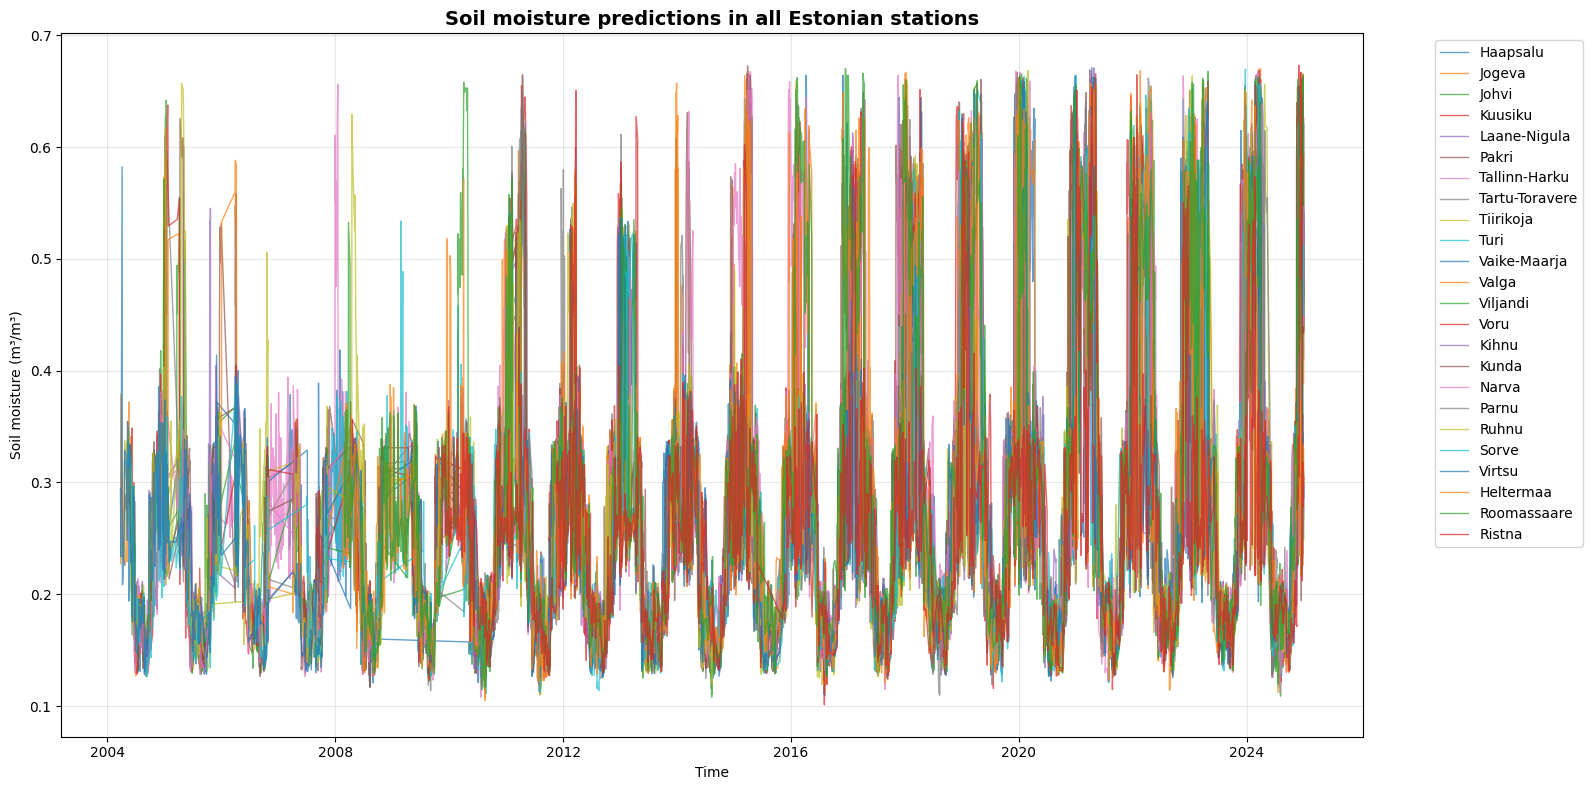

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/andme_project/Estonian_Predictions//plot/haapsalu_subplot.png'

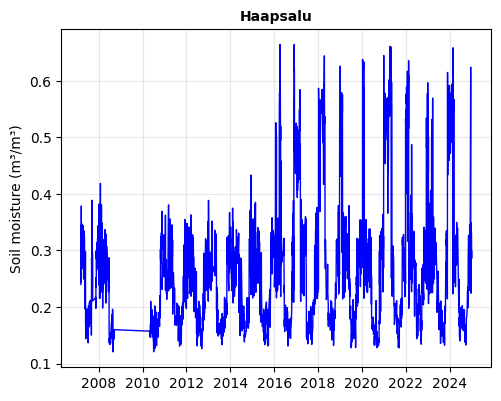

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
for station_name, df_plot in predictions_dict.items():
    plt.plot(df_plot.index, df_plot['predicted_soil_moisture'],
             label=station_name, linewidth=1, alpha=0.7)

plt.title('Soil moisture predictions in all Estonian stations', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Soil moisture (m³/m³)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_path + 'all_stations_combined.png', dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for idx, (station_name, df_plot) in enumerate(predictions_dict.items()):
    if idx < len(axes):
        ax = axes[idx]
        ax.plot(df_plot.index, df_plot['predicted_soil_moisture'],
                color='blue', linewidth=1)
        ax.set_title(station_name, fontsize=10, fontweight='bold')
        ax.set_ylabel('Soil moisture (m³/m³)')
        ax.grid(True, alpha=0.3)

for idx in range(len(predictions_dict), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(output_path + 'individual_stations.png', dpi=300, bbox_inches='tight')

###
# Saving individual stations
for idx, (station_name, df_plot) in enumerate(predictions_dict.items()):
    if idx < len(axes):
        for ax in axes:
            ax.set_visible(False)

        axes[idx].set_visible(True)

        fig.savefig(
            output_path+"/plot/" + f"{station_name.replace(' ', '_').lower()}_subplot.png",
            dpi=300,
            bbox_inches="tight"
        )


        axes[idx].set_visible(False)

plt.show()

In [ ]:
import folium
from folium import plugins
import branca.colormap as cm
from folium.features import DivIcon


station_coords = {
    'Haapsalu': (58.9453, 23.5553),
    'Jogeva': (58.7497, 26.4150),
    'Johvi': (59.3289, 27.3983),
    'Kuusiku': (58.9731, 24.7339),
    'Laane-Nigula': (58.9511, 23.8156),
    'Pakri': (59.3894, 24.0400),
    'Tallinn-Harku': (59.3981, 24.6028),
    'Tartu-Toravere': (58.2642, 26.4614),
    'Tiirikoja': (58.8653, 26.9522),
    'Turi': (58.8086, 25.4092),
    'Vaike-Maarja': (59.1414, 26.2308),
    'Valga': (57.7900, 26.0378),
    'Viljandi': (58.3778, 25.6003),
    'Voru': (57.8464, 27.0194),
    'Kihnu': (58.0986, 23.9703),
    'Kunda': (59.5214, 26.5414),
    'Narva': (59.3894, 28.1092),
    'Parnu': (58.3846, 24.4852),
    'Ruhnu': (57.7833, 23.2589),
    'Sorve': (57.9136, 22.0581),
    'Virtsu': (58.5728, 23.5136),
    'Heltermaa': (58.8664, 23.0469),
    'Roomassaare': (58.2181, 22.5064),
    'Ristna': (58.9208, 22.0664)
}

m = folium.Map(location=[58.5, 25.5], zoom_start=7)

for station_name, df_result in predictions_dict.items():
    if station_name in station_coords:
        lat, lon = station_coords[station_name]
        avg_moisture = df_result['predicted_soil_moisture'].mean()

        folium.CircleMarker(
            location=[lat, lon],
            radius=10,
            popup=f"{station_name}<br>Keskmine: {avg_moisture:.3f}",
            color='blue',
            fill=True,
            fillColor='lightblue'
        ).add_to(m)

m

# Second map with colors

station_values = {
    name: df['predicted_soil_moisture'].mean()
    for name, df in predictions_dict.items()
    if name in station_coords
}

# 2) Värvikaardi skaalad
min_val = min(station_values.values())
max_val = max(station_values.values())

colormap = cm.linear.RdYlGn_11.scale(min_val, max_val)
colormap.caption = "\n\nESTIMATED MEAN SOIL MOISTURE (ALL YEARS) (M³/M³)\n"

# 3) Kaart
m2 = folium.Map(location=[58.7, 25.0], zoom_start=7, tiles="CartoDB positron")

# 4) Kõik punktid värvidega ja indeksiga kaardile
for station_name, avg_moisture in station_values.items():
    lat, lon = station_coords[station_name]

    # Värviline ring
    folium.CircleMarker(
        location=[lat, lon],
        radius=12,
        color=colormap(avg_moisture),
        fill=True,
        fill_color=colormap(avg_moisture),
        fill_opacity=0.9
    ).add_to(m2)

    offset_lat = 0
    offset_lon = 0

    if station_name == "Haapsalu":
        offset_lat = -0.01    # nihuta alla
        offset_lon = 0.02    # nihuta paremale

    if station_name == "Laane-Nigula":
        offset_lat = 0.08   # nihuta üles
        offset_lon = 0.02    # nihuta paremale

    if station_name == "Pakri":
      offset_lat = 0.08   # nihuta üles
      offset_lon = 0.02    # nihuta paremale


    # Tekst ringi kõrvale (ilma klikita)
    folium.map.Marker(
        [lat + offset_lat, lon + offset_lon],
        icon=DivIcon(
            icon_size=(200, 30),
            icon_anchor=(0, 0),
            html=(
                f'<div style="font-size: 17px; color: #000; font-weight: 600;">'
                f'{station_name}: '
                f'<span style="font-size: 22px; font-weight: 800;">{avg_moisture:.3f}</span>'
                f'</div>'
            ),
        ),
    ).add_to(m2)

# 5) Legend
colormap.add_to(m2)

m2


In [ ]:
#------------------#
#     ploting      #
#------------------#
import os
import pandas as pd
import matplotlib.pyplot as plt

folder = "/path/to/file"
files = [f for f in os.listdir(folder) if f.endswith(".csv")]

# Create one figure and one axis
fig, ax = plt.subplots(figsize=(20, 10))

for file in files:
    df = pd.read_csv(os.path.join(folder, file))
    df['date'] = pd.to_datetime(df['date'])
    df_2024 = df[df['date'].dt.year == 2024]

    # Station name from filename
    name = file.split("_")[0]

    # Plot each station’s predictions on the same axis
    ax.plot(df_2024['date'], df_2024['predicted_soil_moisture'], label=name)

# Add labels, title, legend
ax.set_title("Estimated soil moisture of Estonian weather stations (2024)", fontsize=24, fontweight="bold")
ax.set_ylabel("Soil Moisture (m³/m³)", fontsize=18)
ax.set_xlabel("Date", fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

ax.legend(fontsize=14, ncol=3)  # legend with station names

plt.tight_layout()
plt.savefig("/path/soilmoisture_2024_allstations.png", dpi=600, bbox_inches="tight")
plt.show()




